В этом ноутбуке будет подробно изложено решение задачи 2 из летней практики УПМ-212<br> при помощи языка программирования Python.
Так как это вторая часть, то подробно будем останавливаться на относительно новых моментах.

✅Для начала сформулируем задание на примере варианта 16.<br>
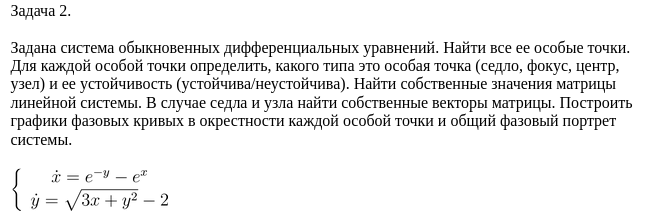<br>
При помощи програмной среды(в нашем случае Python) требуется сделать следующее:
<ul>
    <li>вбить свою систему дифференциальных уравнений;</li>
    <li>решить систему на особые точки;</li>
    <li>найти тейлоровское разложение в окрестности каждой из этих точек;</li>
    <li>в каждой точке сосчитать собственные числа матрицы линейной системы;</li>
    <li>построить фазовый портрет всей системы;</li>
</ul>

In [1]:
import numpy as np
import scipy as sp
import sympy as sy

import matplotlib.pyplot as plt
import phaseportrait

import itertools

In [2]:
import warnings
warnings.filterwarnings('ignore')

✅Из библиотек у нас добавились phaseportrait - еще одна надстройка над matplotlib. Поможет нам в построении фазового портрета системы.<br>
Еще из мелочи - itertools - нужен для упрощения построения множества точек для численного решения системы.<br>
warnings - скроет ненужные предупреждения.

✅Из интересного - библиотека sympy - она используется для символьной математики. Понадобится нам при реализации рядов Тейлора.<br>
Ниже пример использования:

In [24]:
# определяем переменные в математической функции
x, y = sy.symbols('x y')

# определяем функцию
f = sy.Function('f(x, y)')

def f(x, y):
    return (3 * x) ** y

#выведем функцию
f(x, y)

(3*x)**y

In [25]:
# Найдем ее частные производные
f(x, y).diff(x)

y*(3*x)**y/x

In [26]:
f(x, y).diff(y)

(3*x)**y*log(3*x)

In [29]:
# А теперь в точках (x, 0)
f(x, y).diff(x).subs(y, 0)

0

✅Перейдем к решению.

Наша система выглядит так:<br>
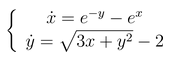

Для начала найдем особые точки системы. Для этого решим однородную систему ниже:<br>
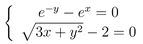

✅Для решения нелинейной однородной системы будем использовать scipy.optimize.fsolve<br>
Для этого перепишем нашу систему в виде функции.<br>
Под капотом эта функция будет принимать в себя какую-то точку - значение переменных и считать значение системы в этой точке.<br>
Остальную работу на себя берет scipy.<br>
В fsolve необходимо передать систему, описанную функцией Python и точку, в которой стартует численный поиск решения.<br>
Так как у системы решений несколько, то и точку нам нужно подставить не одну.<br>
Аналитически можно понять, что x и y по модулю не превосходят 4 и не меньше 1.<br>
При помощи itertools.product сформируем множество таких точек.<br>
Далее в каждой точке из этого множества будем искать решение. Результат будем выводить.

In [30]:
def homo_system(vars: list | tuple) -> list:
    x, y = vars
    eq1 = np.exp(-y) - np.exp(x)
    eq2 = np.sqrt(3 * x + y ** 2) - 2
    return [eq1, eq2]

In [31]:
# предполагаемые решения системы(легко определить, взглянув на систему)
dots = itertools.product(range(1, 5), repeat=2)

for dot in dots:
    solution = sp.optimize.fsolve(homo_system, dot)
    print(f'Точка: {dot}, Решение: {solution}')

Точка: (1, 1), Решение: [-4.  4.]
Точка: (1, 2), Решение: [-4.  4.]
Точка: (1, 3), Решение: [-4.  4.]
Точка: (1, 4), Решение: [-4.  4.]
Точка: (2, 1), Решение: [-4.  4.]
Точка: (2, 2), Решение: [-4.  4.]
Точка: (2, 3), Решение: [-4.  4.]
Точка: (2, 4), Решение: [-4.  4.]
Точка: (3, 1), Решение: [ 1. -1.]
Точка: (3, 2), Решение: [ 1. -1.]
Точка: (3, 3), Решение: [ 1. -1.]
Точка: (3, 4), Решение: [ 1. -1.]
Точка: (4, 1), Решение: [ 1. -1.]
Точка: (4, 2), Решение: [ 1. -1.]
Точка: (4, 3), Решение: [ 1. -1.]
Точка: (4, 4), Решение: [ 1. -1.]


Итак, особые точки системы - (-4, 4) и (1, -1)

Исследуем точки. Для этого будем смещать цент системы к данным точкам при помощи замен.

В окрестности точки (-4, 4) система будет выглядеть так:<br>
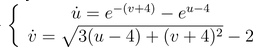<br>
Найдем коэффициенты линейных членов правой части системы в ряде Тейлора.<br>
Для этого сначала определим наши функции уже от двух переменных при помощи библиотеки SymPy.

In [5]:
# определяем переменные
u, v = sy.symbols('u v')

In [35]:
# определяем уравнения системы
eq1 = sy.Function('eq1')
eq2 = sy.Function('eq2')

def eq1(u, v):
    return sy.exp(-(v + 4)) - sy.exp(u - 4)

def eq2(u, v):
    return sy.sqrt(3 * (u - 4) + (v + 4) ** 2) - 2

Определим функцию для получения ряда Тейлора-Маклорена<br>
Для этого будем вычислять новые частные производные на каждой итерации.

In [36]:
def TeylorMcLaurin(func: sy.Function, n: int) -> sy.core.add.Add:
    """
    func - функция(двух переменных), которую нужно разложить в ряд Тейлора-Маклорена
    n - число членов(полных дифференциалов)
    """
    # на случай, если символы были не определены
    u, v = sy.symbols('u v')
    
    curr_f_u = func(u, v)
    curr_f_v = func(u, v)
    res_f = func(u, v).subs(u, 0).subs(v, 0)
    
    for iter in range(1, n + 1):
        curr_f_u = curr_f_u.diff(u).subs(u, 0).subs(v, 0) * (u ** iter)
        curr_f_v = curr_f_v.diff(v).subs(u, 0).subs(v, 0) * (v ** iter)
        res_f += curr_f_u + curr_f_v
    
    return res_f

Найдем линейные члены

In [37]:
eq1(u, v).subs(u, 0).subs(v, 0) + eq1(u, v).diff(u).subs(u, 0).subs(v, 0) * u + eq1(u, v).diff(v).subs(u, 0).subs(v, 0) * v

-u*exp(-4) - v*exp(-4)

In [38]:
eq2(u, v).subs(u, 0).subs(v, 0) + eq2(u, v).diff(u).subs(u, 0).subs(v, 0) * u + eq2(u, v).diff(v).subs(u, 0).subs(v, 0) * v

3*u/4 + 2*v

Получить полный ряд

In [39]:
TeylorMcLaurin(eq1, 3)

-u**2*exp(-4) - u*exp(-4) - v**2*exp(-4) - v*exp(-4)

In [40]:
TeylorMcLaurin(eq2, 3)

3*u**2/4 + 3*u/4 + 2*v**2 + 2*v

Найдем для матрицы линейной системы собственные значения и собственные вектора.<br>
Для этого будем использовать linalg - подмодуль numpy.<br>
Его метод eig вернет нам кортеж из собственных значений и собственных векторов матрицы линейной системы, полученной выше.

In [41]:
A = np.array(
    [[-1 / np.exp(4), -1 / np.exp(4)],
    [3 / 4, 2]]
)

eigen_values, eigen_vectors = np.linalg.eig(A)

In [42]:
for e_val, e_vec in zip(eigen_values, eigen_vectors):
    print(f'Собственное число: {e_val}, Собственный вектор: {e_vec}')

Собственное число: -0.01148649576723848, Собственный вектор: [-0.93698719  0.00910515]
Собственное число: 1.993170856878504, Собственный вектор: [ 0.34936371 -0.99995855]


Проделаем все то же самое и для точки (1, -1)

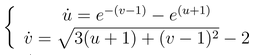

In [43]:
# определяем уравнения системы
eq1 = sy.Function('eq1')
eq2 = sy.Function('eq2')

def eq1(u, v):
    return sy.exp(-(v - 1)) - sy.exp(u + 1)

def eq2(u, v):
    return sy.sqrt(3 * (u + 1) + (v - 1) ** 2) - 2

Найдем линейные члены

In [44]:
eq1(u, v).subs(u, 0).subs(v, 0) + eq1(u, v).diff(u).subs(u, 0).subs(v, 0) * u + eq1(u, v).diff(v).subs(u, 0).subs(v, 0) * v

-E*u - E*v

In [45]:
eq2(u, v).subs(u, 0).subs(v, 0) + eq2(u, v).diff(u).subs(u, 0).subs(v, 0) * u + eq2(u, v).diff(v).subs(u, 0).subs(v, 0) * v

3*u/4 - v/2

Получить полный ряд

In [46]:
TeylorMcLaurin(eq1, 3)

-E*u**2 - E*u - E*v**2 - E*v

In [47]:
TeylorMcLaurin(eq2, 3)

3*u**2/4 + 3*u/4 - v**2/2 - v/2

In [48]:
A = np.array(
    [[-np.exp(1), -np.exp(1)],
    [3 / 4, -1 / 2]]
)

eigen_values, eigen_vectors = np.linalg.eig(A)

In [49]:
for e_val, e_vec in zip(eigen_values, eigen_vectors):
    print(f'Собственное число: {e_val}, Собственный вектор: {e_vec}')

Собственное число: (-1.6091409142295225+0.8991761805821943j), Собственный вектор: [-0.88529916+0.j -0.88529916-0.j]
Собственное число: (-1.6091409142295225-0.8991761805821943j), Собственный вектор: [0.36122874+0.29284672j 0.36122874-0.29284672j]


Построим полный портрет системы

In [50]:
# для построения портрета переопределим исходную систему
def ode(x, y):
    dydt = [np.exp(-y) - np.exp(x), np.sqrt(3 * x + y ** 2) - 2]
    return dydt

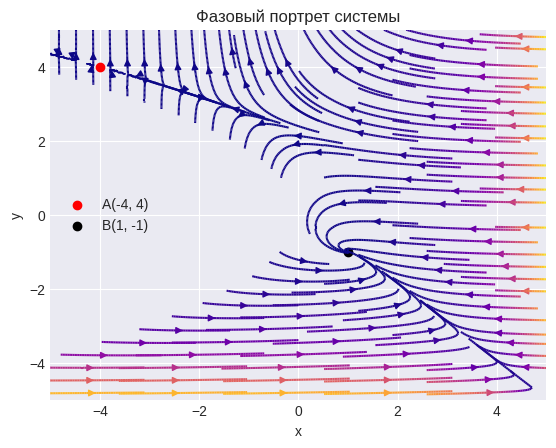

In [51]:
plt.style.use('seaborn-v0_8-darkgrid')

portrait = phaseportrait.PhasePortrait2D(ode, [-5, 5], xlabel='x', ylabel='y', maxLen=100, odeint_method='euler', color='plasma')
portrait.plot()
plt.scatter(-4, 4, color='red', label='A(-4, 4)')
plt.scatter(1, -1, color='black', label='B(1, -1)')

plt.title('Фазовый портрет системы')
plt.legend(loc='best')
plt.show()